In [93]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import ast
from utils import *

In [94]:
BASE_ERROR = 0.8
MAX_DEG=5
drop_features=["is_Animation","is_Foreign","is_Music","is_History","is_War","is_Mystery"]

In [95]:
def load_data():
    movie_df = pd.read_csv(MOVIE_DATA)
    movie_df = movie_df[movie_df.revenue >= 1000000]
    movie_df["genres"] = movie_df["genres"].apply(ast.literal_eval)

    all_genre_list = get_all_genres(movie_df)
    for g in all_genre_list:
        g_name = "is_" + g
        movie_df[g_name] = movie_df["genres"].apply(check_gtype, g=g)

    #    movie_df.to_csv(TMP_DUMP)

    XY_df = movie_df.filter(like="is_")
    for f in drop_features:
        del XY_df[f]
    #del XY_df["is_Western"]
    #del XY_df["is_Documentary"]
    #del XY_df["is_Music"]
    #del XY_df["is_War"]
    #del XY_df["is_History"]
    #del XY_df["is_Mystery"]

    XY_df["revenue"] = movie_df["revenue"] / 100000000
    XY = XY_df.to_numpy()
    Y = XY[:, -1]
    X = np.delete(XY, -1, axis=1)
    # XY_df.to_csv(TMP_DUMP)
    X_train = X[1:]
    Y_train = Y[1:]
    return (X_train, Y_train)


In [96]:
X_all_f, y = load_data()
X_features = [
    "is_Action",
    "is_Adventure",
    "is_Fantasy",
    "is_Science Fiction",
    "is_Crime",
    "is_Drama",
    "is_Thriller",
    "is_Animation",
    "is_Family",
    "is_Western",
    "is_Comedy",
    "is_Romance",
    "is_Horror",
    "is_Mystery",
    "is_History",
    "is_War",
    "is_Music",
    "is_Documentary",
    "is_Foreign",
]
X_features = [x for x in X_features if x not in drop_features]


C:\Users\Ananthi Balakrishnan\AppData\Local\Temp\ipykernel_15724\290894372.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  XY_df["revenue"] = movie_df["revenue"] / 100000000


In [97]:
def split_data(X,y):
    # Split Data
    print(f"Overall data set size: {X.shape}")
    X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.40, random_state=1)
    X_test, X_cv, y_test, y_cv = train_test_split(X_, y_, test_size=0.20, random_state=1)
    print(f"Training data set size: {X_train.shape}")
    print(f"Validation data set size: {X_cv.shape}")
    print(f"Test data set size: {X_test.shape}")
    return X_train,X_cv,X_test, y_train,y_cv,y_test

In [98]:
def train_linear_model (X_train,X_cv,X_test, y_train,y_cv,y_test):
    # Initialize the class
    linear_model = LinearRegression()
    # Train the model
    linear_model.fit(X_train, y_train)

    # Feed the training set and get the predictions
    yhat = linear_model.predict(X_train)
    # Use scikit-learn's utility function and divide by 2
    print(f"training MSE : {mean_squared_error(y_train, yhat) / 2}")

    # Feed the validation set and get the predictions
    yhat_cv = linear_model.predict(X_cv)
    print(
        f"Validation MSE : {mean_squared_error(y_cv, yhat_cv) / 2}"
    )

    # Feed the test set and get the predictions
    yhat_test = linear_model.predict(X_test)
    print(f"Test MSE : {mean_squared_error(y_test, yhat_test) / 2}")


In [99]:
def find_best_poly_fit (X_train,X_cv,X_test, y_train,y_cv,y_test):# Find best polynomial
    # Instantiate the class to make polynomial features
    train_mses = []
    cv_mses = []
    degrees = range(1, MAX_DEG)
    models = []
    polys = []

    for d in degrees:
        print(f"POLY DEGREE: {d}")
        poly = PolynomialFeatures(degree=d, include_bias=False)
        # Compute the number of features and transform the training set
        X_train_mapped = poly.fit_transform(X_train)
        polys.append(poly)

        model = LinearRegression()
        model.fit(X_train_mapped, y_train)
        models.append(model)
        yhat = model.predict(X_train_mapped)
        # Use scikit-learn's utility function and divide by 2
        train_mse = mean_squared_error(y_train, yhat) / 2

        print(f"training MSE : {train_mse}")
        train_mses.append(train_mse)

        # Feed the validation set and get the predictions
        X_cv_mapped = poly.fit_transform(X_cv)
        yhat_cv = model.predict(X_cv_mapped)

        cv_mse = mean_squared_error(y_cv, yhat_cv) / 2
        print(f"Validation MSE : {cv_mse}")
        cv_mses.append(cv_mse)
    plt.plot(degrees, train_mses, color="r",marker="o",label="training MSE")
    plt.plot(degrees, cv_mses, color="b",marker="x",label="CV MSE")
    plt.title("degree of polynomial vs. train and CV MSEs")
    plt.legend
    plt.show()

    degree = np.argmin(cv_mses) + 1
    print(f"Lowest CV MSE is found in the model with degree={degree}")
    X_test_mapped = polys[degree-1].fit_transform(X_test)
    yhat_test = models[degree-1].predict(X_test_mapped)

    test_mse = mean_squared_error(y_test, yhat_test) / 2
    print(f"Test MSE : {test_mse}")
    return cv_mses[degree-1]


Overall data set size: (3183, 12)
Training data set size: (1909, 12)
Validation data set size: (255, 12)
Test data set size: (1019, 12)
training MSE : 1.3772158533776935
Validation MSE : 1.4614612135288647
Test MSE : 1.2698877535911086
POLY DEGREE: 1
training MSE : 1.3772158533776935
Validation MSE : 1.4614612135288647
POLY DEGREE: 2
training MSE : 1.261004057135019
Validation MSE : 1.242806789320209
POLY DEGREE: 3
training MSE : 1.151382851504178
Validation MSE : 1.4331474194091499e+21
POLY DEGREE: 4
training MSE : 1.2316496048247352
Validation MSE : 6.221802669376913e+24


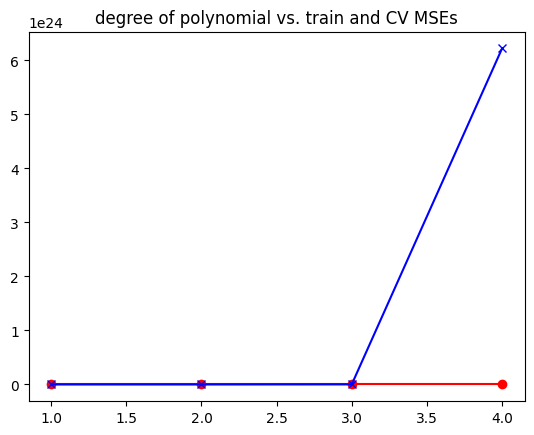

Lowest CV MSE is found in the model with degree=2
Test MSE : 8.770052219860117e+19


np.float64(1.242806789320209)

In [100]:
#Experiment feature selection
#num_features = len(X_features)
#feat_min_mse=[]
#for i in range(num_features-1):
    # print ("-"*40)
    # print (f"Dropping feature {X_features[i]},{X_features[i+1]}")
    # print ("-"*40)
    # X=np.delete(X_all_f,i,1)
    # X=np.delete(X_all_f,i,1)

X_train,X_cv,X_test, y_train,y_cv,y_test = split_data(X,y)
train_linear_model(X_train,X_cv,X_test, y_train,y_cv,y_test)
find_best_poly_fit(X_train,X_cv,X_test, y_train,y_cv,y_test)
#feat_min_mse.append(min_cv_mse)
#print(f"Min cv mse while dropping feature {X_features[i]},{X_features[i+1]}: {min_cv_mse}")
